<a href="https://colab.research.google.com/github/dinno797/Symptom-to-disease-and-Medicines-prediction-model-using-XG-BOOST/blob/main/Symptom_to_Disease_and_Medicine_Prediction_using_xg_boost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Replace with actual file path and delimiter
df = pd.read_csv('/content/Disease and symptoms dataset.csv')

# Assuming symptom columns start at a known index (e.g., column 2 onward)
symptom_columns = df.columns.tolist()[1:]  # adjust index as needed

print("Total symptoms:", len(symptom_columns))
for symptom in symptom_columns:
    print(symptom)


Total symptoms: 377
anxiety and nervousness
depression
shortness of breath
depressive or psychotic symptoms
sharp chest pain
dizziness
insomnia
abnormal involuntary movements
chest tightness
palpitations
irregular heartbeat
breathing fast
hoarse voice
sore throat
difficulty speaking
cough
nasal congestion
throat swelling
diminished hearing
lump in throat
throat feels tight
difficulty in swallowing
skin swelling
retention of urine
groin mass
leg pain
hip pain
suprapubic pain
blood in stool
lack of growth
emotional symptoms
elbow weakness
back weakness
pus in sputum
symptoms of the scrotum and testes
swelling of scrotum
pain in testicles
flatulence
pus draining from ear
jaundice
mass in scrotum
white discharge from eye
irritable infant
abusing alcohol
fainting
hostile behavior
drug abuse
sharp abdominal pain
feeling ill
vomiting
headache
nausea
diarrhea
vaginal itching
vaginal dryness
painful urination
involuntary urination
pain during intercourse
frequent urination
lower abdominal pain


In [ ]:
# If needed (run once in your env):
# pip install xgboost==2.0.3 scikit-learn==1.4.2 pandas==2.2.2 numpy==1.26.4 joblib==1.3.2 matplotlib==3.8.4

import os, json, math, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from xgboost import XGBClassifier


In [ ]:
DATA_PATH = "/content/Disease and symptoms dataset.csv"
TARGET_COL = "diseases"

# Try reading as CSV; if it's TSV, change sep='\t'
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("Columns (first 20):", df.columns[:20].tolist())

# If you're unsure of the target col name, try to auto-guess:
if TARGET_COL not in df.columns:
    # guess: pick the only object/categorical col with many unique values
    obj_cols = [c for c in df.columns if df[c].dtype == 'object']
    guess = None
    if obj_cols:
        uniq_counts = {c: df[c].nunique() for c in obj_cols}
        guess = max(uniq_counts, key=uniq_counts.get)
    raise ValueError(f"TARGET_COL '{TARGET_COL}' not found. Possible target: {guess} from {obj_cols}")

# Basic sanity: symptoms should be numeric/binary
feature_cols = [c for c in df.columns if c != TARGET_COL]
print(f"Detected {len(feature_cols)} feature columns and 1 target column '{TARGET_COL}'.")


Shape: (61105, 378)
Columns (first 20): ['diseases', 'anxiety and nervousness', 'depression', 'shortness of breath', 'depressive or psychotic symptoms', 'sharp chest pain', 'dizziness', 'insomnia', 'abnormal involuntary movements', 'chest tightness', 'palpitations', 'irregular heartbeat', 'breathing fast', 'hoarse voice', 'sore throat', 'difficulty speaking', 'cough', 'nasal congestion', 'throat swelling', 'diminished hearing']
Detected 377 feature columns and 1 target column 'diseases'.


In [ ]:
# Label encode diseases
le = LabelEncoder()
y = le.fit_transform(df[TARGET_COL].astype(str))

# Convert features to numeric (0/1).
# If already 0/1 ints, this is a no-op; otherwise try to coerce.
X = df[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.uint8)

n_classes = len(le.classes_)
print("Classes:", n_classes)
print("Sample diseases:", le.classes_[:10])

Classes: 203
Sample diseases: ['abdominal hernia' 'abscess of the lung' 'achalasia' 'actinic keratosis'
 'acute bronchospasm' 'acute glaucoma' 'acute otitis media'
 'acute pancreatitis' 'acute sinusitis' 'allergy']


In [ ]:
# Keep a test set aside
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# From the training set, carve out a validation set for early stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

print("Train:", X_tr.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (41551, 377) Val: (7333, 377) Test: (12221, 377)


In [ ]:
# In multiclass, we’ll weight samples inversely to class frequency
class_counts = Counter(y_tr)
total = len(y_tr)
class_weight = {c: total / (n_classes * cnt) for c, cnt in class_counts.items()}

w_tr = np.array([class_weight[c] for c in y_tr], dtype=np.float32)
w_val = np.array([class_weight.get(c, 1.0) for c in y_val], dtype=np.float32)


In [ ]:
dtrain = xgb.DMatrix(X_tr, label=y_tr, weight=w_tr)
dval   = xgb.DMatrix(X_val, label=y_val)

params = {
    "objective": "multi:softprob",
    "num_class": n_classes,
    "max_depth": 6,          # lower depth to reduce overfitting
    "eta": 0.05,             # smaller learning rate
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "eval_metric": ["mlogloss", "merror"],
    "seed": 42               # makes results reproducible
}

evallist = [(dtrain, "train"), (dval, "eval")]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=4000,
    evals=evallist,
    early_stopping_rounds=100,
    verbose_eval=50
)


[0]	train-mlogloss:3.95890	train-merror:0.40437	eval-mlogloss:4.29340	eval-merror:0.58734
[50]	train-mlogloss:0.42072	train-merror:0.03311	eval-mlogloss:0.59447	eval-merror:0.07664
[100]	train-mlogloss:0.15730	train-merror:0.02473	eval-mlogloss:0.29741	eval-merror:0.07091
[150]	train-mlogloss:0.09887	train-merror:0.02149	eval-mlogloss:0.22610	eval-merror:0.06818
[200]	train-mlogloss:0.07875	train-merror:0.01994	eval-mlogloss:0.20220	eval-merror:0.06859
[250]	train-mlogloss:0.06928	train-merror:0.01935	eval-mlogloss:0.19287	eval-merror:0.06791
[272]	train-mlogloss:0.06653	train-merror:0.01861	eval-mlogloss:0.19097	eval-merror:0.06791


In [ ]:
print("Best iteration:", bst.best_iteration)

Best iteration: 172


In [ ]:
# Convert test set to DMatrix
dtest = xgb.DMatrix(X_test)

# Predict probabilities
probs_test = bst.predict(dtest)           # bst = Booster from xgb.train()
pred_test = np.argmax(probs_test, axis=1)

# Metrics
from sklearn.metrics import accuracy_score, f1_score
acc = accuracy_score(y_test, pred_test)
f1_micro = f1_score(y_test, pred_test, average='micro')
f1_macro = f1_score(y_test, pred_test, average='macro')

# Top-k accuracy helper
def topk_accuracy(probs, y_true, k=3):
    topk = np.argsort(probs, axis=1)[:, -k:]
    hits = sum(yt in row for yt, row in zip(y_true, topk))
    return hits / len(y_true)

top3 = topk_accuracy(probs_test, y_test, k=3)
top5 = topk_accuracy(probs_test, y_test, k=5)

print(f"Accuracy: {acc:.4f}")
print(f"F1-micro: {f1_micro:.4f} | F1-macro: {f1_macro:.4f}")
print(f"Top-3 Accuracy: {top3:.4f} | Top-5 Accuracy: {top5:.4f}")


Accuracy: 0.9296
F1-micro: 0.9296 | F1-macro: 0.8950
Top-3 Accuracy: 0.9865 | Top-5 Accuracy: 0.9962


                                    feature  importance
247                                  thirst  119.178253
124                      recent weight loss   83.555359
52                          vaginal dryness   79.439384
145                            feeling cold   71.818100
214                      stiffness all over   68.701523
117             knee stiffness or tightness   67.260277
244                              penis pain   64.314705
194                          wrist weakness   61.503132
215  muscle cramps, contractures, or spasms   53.915733
82                               cross-eyed   53.006588
195                              hemoptysis   52.146023
160                          tongue lesions   48.578846
226                         eyelid swelling   45.279690
184                                  melena   44.252216
111                           knee weakness   41.636173
96                                impotence   41.456924
35                               flatulence   40

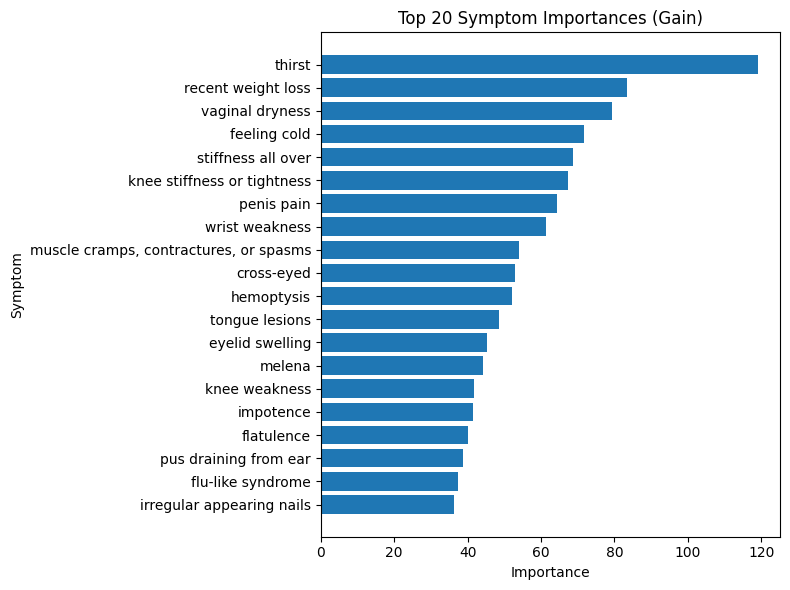

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get importance scores directly
importance = bst.get_score(importance_type='gain')

# Convert to DataFrame
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),    # already the feature names
    'importance': list(importance.values())
})

# Sort descending
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Show top 20
print(importance_df.head(20))

# Plot top 20
plt.figure(figsize=(8,6))
plt.barh(importance_df['feature'][:20][::-1], importance_df['importance'][:20][::-1])
plt.title("Top 20 Symptom Importances (Gain)")
plt.xlabel("Importance")
plt.ylabel("Symptom")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# X.columns = list of all symptom names in your dataset
mlb = MultiLabelBinarizer()
mlb.fit([X.columns])  # Fit on the full set of symptoms

# If you want, you can also check classes
print(mlb.classes_)


['abdominal distention' 'abnormal appearing skin'
 'abnormal appearing tongue' 'abnormal breathing sounds'
 'abnormal involuntary movements' 'abnormal movement of eyelid'
 'abnormal size or shape of ear' 'absence of menstruation'
 'abusing alcohol' 'ache all over' 'acne or pimples' 'allergic reaction'
 'ankle pain' 'ankle stiffness or tightness' 'ankle swelling'
 'ankle weakness' 'antisocial behavior' 'anxiety and nervousness' 'apnea'
 'arm cramps or spasms' 'arm lump or mass' 'arm pain'
 'arm stiffness or tightness' 'arm swelling' 'arm weakness'
 'back cramps or spasms' 'back mass or lump' 'back pain'
 'back stiffness or tightness' 'back swelling' 'back weakness'
 'bedwetting' 'bladder mass' 'bleeding from ear' 'bleeding from eye'
 'bleeding gums' 'bleeding in mouth' 'bleeding or discharge from nipple'
 'blindness' 'blood clots during menstrual periods' 'blood in stool'
 'blood in urine' 'bones are painful' 'bowlegged or knock-kneed'
 'breathing fast' 'bumps on penis' 'burning abdomin

In [ ]:
def symptoms_to_input(symptom_list):
    """
    Convert a list of symptoms to a correctly ordered DataFrame
    for XGBoost prediction
    """
    # Create empty row with all symptoms 0
    row = pd.DataFrame(0, index=[0], columns=X_train.columns)  # Use training columns

    # Set 1 for symptoms present
    for symptom in symptom_list:
        if symptom in row.columns:
            row.at[0, symptom] = 1
    return row


In [ ]:
def predict_disease(symptom_list, model, top_k=5):
    """
    symptom_list: list of strings
    model: trained Booster
    top_k: return top k predictions
    """
    X_input = symptoms_to_input(symptom_list)
    dmatrix_input = xgb.DMatrix(X_input)  # feature names now match training
    probs = model.predict(dmatrix_input)[0]
    top_indices = probs.argsort()[-top_k:][::-1]
    top_diseases = [y_classes[i] for i in top_indices]
    top_probs = [probs[i] for i in top_indices]
    return list(zip(top_diseases, top_probs))


In [ ]:
y_classes = list(le.classes_)

symptoms = ["Shortness of Breathe", "Tightness in Chest", "Cough","wheezing"]
top_predictions = predict_disease(symptoms, bst, top_k=5)

for disease, prob in top_predictions:
    print(f"{disease}: {prob:.3f}")


asthma: 0.424
acute bronchospasm: 0.297
chronic obstructive pulmonary disease (copd): 0.236
presbyacusis: 0.001
injury to the finger: 0.000


In [ ]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("zenitsu09/medicine-dataset-v1")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

Medicine_Details.csv.zip:   0%|          | 0.00/782k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11825 [00:00<?, ? examples/s]

In [ ]:
df = ds["train"].to_pandas()

print("Columns in dataset:", df.columns.tolist())
print(df.head())  # just to inspect

Columns in dataset: ['Medicine Name', 'Composition', 'Uses', 'Side_effects', 'Image URL', 'Manufacturer', 'Excellent Review %', 'Average Review %', 'Poor Review %']
              Medicine Name  \
0   Avastin 400mg Injection   
1  Augmentin 625 Duo Tablet   
2       Azithral 500 Tablet   
3          Ascoril LS Syrup   
4         Aciloc 150 Tablet   

                                         Composition  \
0                                Bevacizumab (400mg)   
1    Amoxycillin  (500mg) +  Clavulanic Acid (125mg)   
2                               Azithromycin (500mg)   
3  Ambroxol (30mg/5ml) + Levosalbutamol (1mg/5ml)...   
4                                 Ranitidine (150mg)   

                                                Uses  \
0   Cancer of colon and rectum Non-small cell lun...   
1                  Treatment of Bacterial infections   
2                  Treatment of Bacterial infections   
3                      Treatment of Cough with mucus   
4  Treatment of Gastroesophagea

In [ ]:
!pip install fuzzywuzzy[speedup]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 53.3 MB/s eta 0:00:00


In [ ]:
from fuzzywuzzy import process

# Step 1: Create mapping from "Uses" → list of medicine dicts (Name + Image + Side Effects)
disease_to_med = (
    df.groupby("Uses")
    .apply(lambda g: [{"name": row["Medicine Name"],
                       "image": row["Image URL"],
                       "side_effects": row["Side_effects"]} for _, row in g.iterrows()])
    .to_dict()
)

# Step 2: Helper function to find closest "Uses" entry for predicted disease
def get_medicines_for_disease(predicted_disease, disease_to_med, top_n=5):
    match, score = process.extractOne(predicted_disease, disease_to_med.keys())
    if score > 60:  # threshold
        return match, disease_to_med[match][:top_n]
    else:
        return None, [{"name": "No medicine found", "image": "-", "side_effects": "-"}]

# Step 3: Show results with images and side effects
for disease, prob in top_predictions:
    print(f"\nPredicted Disease: {disease} (prob: {prob:.3f})")
    matched_use, meds = get_medicines_for_disease(disease, disease_to_med, top_n=5)
    print(f"Matched Uses: {matched_use}")
    print("Suggested Medicines:")
    for med in meds:
        print(f"  - {med['name']}")
        print(f"    Image: {med['image']}")
        print(f"    Side Effects: {med['side_effects']}")


/tmp/ipython-input-3187170585.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: [{"name": row["Medicine Name"],



Predicted Disease: asthma (prob: 0.424)
Matched Uses:  Asthma
Suggested Medicines:
  - Aerocort Inhaler
    Image: https://onemg.gumlet.io/l_watermark_346,w_480,h_480/a_ignore,w_480,h_480,c_fit,q_auto,f_auto/cropped/zz57ek6tsj8boa5kwj1q.jpg
    Side Effects: Hoarseness of voice Headache Dizziness Pharyngitis Vomiting Bronchitis inflammation of the airways Dryness in mouth Cough Application site irritation Nausea Gastrointestinal motility disorder Thrush Throat irritation
  - Aerocort Forte Rotacap
    Image: https://onemg.gumlet.io/l_watermark_346,w_480,h_480/a_ignore,w_480,h_480,c_fit,q_auto,f_auto/cropped/axb1kggiuzbxmrs0eht4.jpg
    Side Effects: Hoarseness of voice Headache Dizziness Pharyngitis Vomiting Bronchitis inflammation of the airways Dryness in mouth Cough Application site irritation Nausea Gastrointestinal motility disorder Thrush Throat irritation
  - Arophyll HD 10mg/120mg/200mg Tablet
    Image: https://onemg.gumlet.io/l_watermark_346,w_480,h_480/a_ignore,w_480,h_480,